# Dendritic Target Propagation in spiking neurons

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import EIANN.EIANN as eiann
from EIANN import utils as ut
eiann.plot.update_plot_defaults()
root_dir = ut.get_project_root()

%load_ext autoreload
%autoreload 2


### 1. Load pre-trained EIANN: 
### Dendritic Target Propagation (LDS, Top-down Weight Symmetry)

In [ ]:
network_name = "20241009_EIANN_2_hidden_mnist_BP_like_config_5J_complete_optimized"
network_seed = 66049
data_seed = 257

saved_network_path = root_dir + f"/EIANN/data/mnist/{network_name}_{network_seed}_{data_seed}.pkl"
network = ut.load_network(saved_network_path)
network.name = network_name

### 2. Extract bottom-up and top-down inputs to a specific neuron

In [ ]:
train_dataloader, val_dataloader, test_dataloader, data_generator = ut.get_MNIST_dataloaders()

In [ ]:
# Load weights from a saved checkpoint halfway through training
# state_dict = network.param_history[100] 
state_dict = network.param_history[-1] 
network.load_state_dict(state_dict)

In [ ]:
idx, data_sample, target = next(iter(train_dataloader))

output = network.forward(data_sample, store_dynamics=True, no_grad=False)
network.update_forward_state(store_dynamics=True)

for backward in network.backward_methods:
    backward(network, output, torch.squeeze(target), store_history=True, store_dynamics=True)

# Step weights and biases
for i, post_layer in enumerate(network):
    for post_pop in post_layer:
        if post_pop.include_bias:
            post_pop.bias_learning_rule.step()
        for projection in post_pop:
            projection.learning_rule.step()

In [ ]:
network.H2.E.activity_dynamics.shape

In [ ]:
network.H2.E.dendritic_state.shape

In [ ]:
network.H2.E.forward_dendritic_state_steps.shape

In [ ]:
network.H2.E.backward_dendritic_state.shape

In [ ]:
network.H2.E.backward_activity

In [ ]:
network.backward_methods

In [ ]:
network.forward_steps

### 3. Run equivalent LIF neuron simulation

In [ ]:
network.H2.E.incoming_projections

In [ ]:
network.Output.E.projections['H2']['E']

In [ ]:
network.H2.E.incoming_projections['H2E_H1E'].weight[unit_id].shape

In [ ]:
neuron_tau

Simulation length: 150 ms
Membrane time constant: 30 ms
Poisson rates range: 0.00 - 200.00 Hz
Total spikes generated: 3
Average firing rate: 20.00 Hz


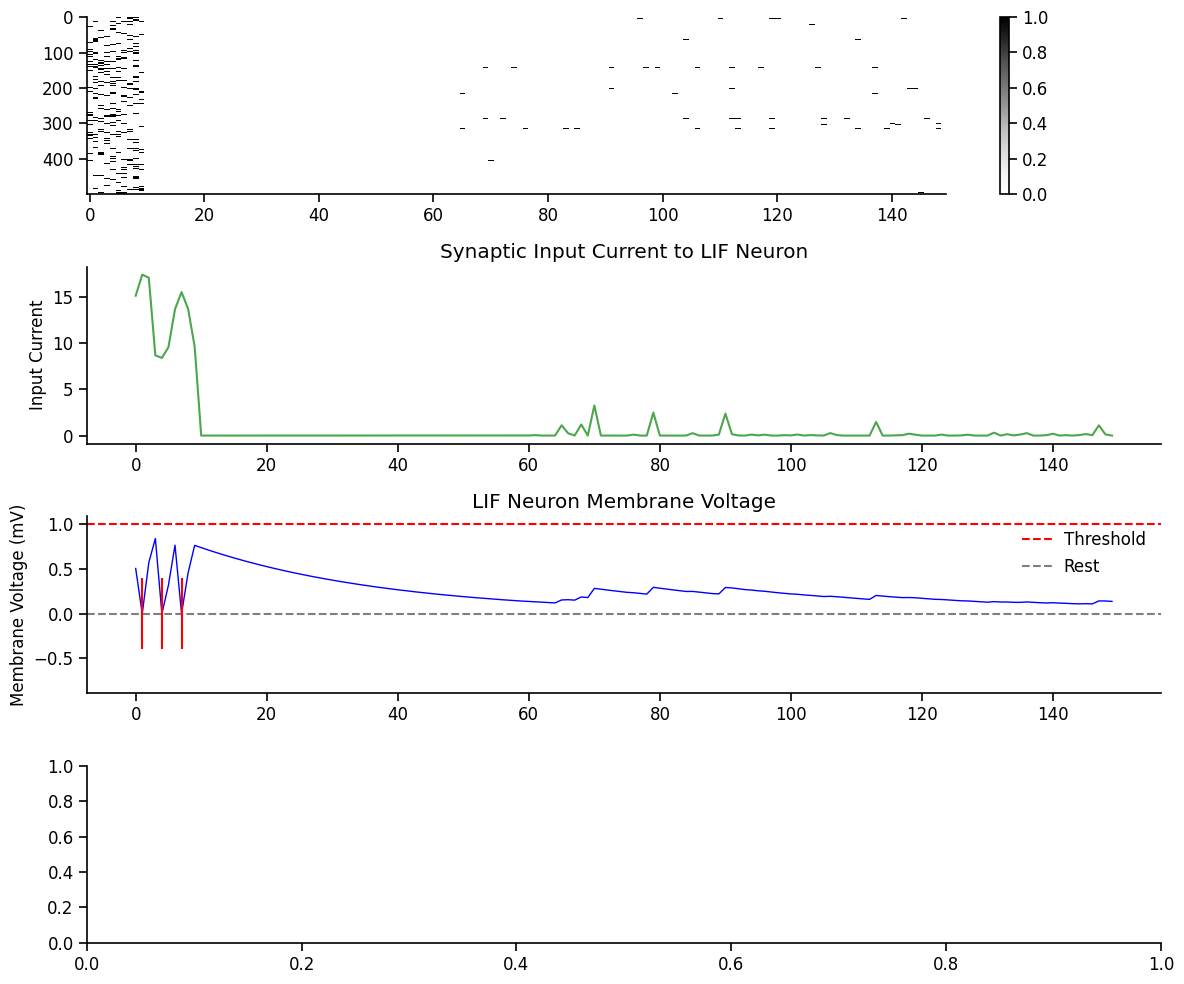

Total input spikes: 83
Output spikes: 3


In [225]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters from your setup
time_coefficient = 10  # ms per time step

# Assuming these come from your network object:
population = network.H2.E
pre_population = network.H1.E
time_steps = network.forward_steps * time_coefficient
neuron_tau = network.tau * time_coefficient
print(f"Simulation length: {time_steps} ms")
print(f"Membrane time constant: {neuron_tau} ms")

# LIF neuron parameters
v_rest = 0.0      # resting potential (mV)
v_threshold = 1.0 # spike threshold (mV)
v_reset = 0.0     # reset potential (mV)
dt = 1.0          # time step (ms)

# Synaptic weights
unit_idx = 0
pre_activations = pre_population.activity_dynamics
weight_scale = 100
synaptic_weights = population.incoming_projections['H2E_H1E'].weight[unit_idx] * weight_scale

# Initialize neuron state
v_membrane = v_rest
spike_times = []
voltage_trace = []
input_current_trace = []
pre_spikes = []

# Convert RNN activations to Poisson rates
# Assuming activations are roughly in [0, 2] range, scale to reasonable firing rates
max_rate = 200.0  # Hz
poisson_rates = max_rate * pre_activations / pre_activations.max()  # scale to 0-100 Hz
print(f"Poisson rates range: {poisson_rates.min():.2f} - {poisson_rates.max():.2f} Hz")

# Main simulation loop
for rnn_step in range(network.forward_steps):
    for t in range(time_coefficient):
        total_time = rnn_step*time_coefficient + t

        # Generate Poisson spikes for presynaptic neurons
        presynaptic_rates = poisson_rates[rnn_step]  # [500] rates in Hz        
        spike_probs = presynaptic_rates * dt / 1000.0     # Probability of spike in 1ms = rate * dt / 1000
        presynaptic_spikes = torch.bernoulli(spike_probs)  # [500] binary spikes
    

        # presynaptic_spikes = torch.poisson(presynaptic_rates * dt / 1000.0) # Probability of spike in 1ms = rate * dt / 1000
        # pre_spike_times = total_time * np.ones(pre_population.size) * (presynaptic_spikes.numpy()==1)        

        # # LIF dynamics: tau * dv/dt = -(v - v_rest) + I
        input_current = torch.sum(presynaptic_spikes * synaptic_weights).numpy()
        dv_dt = (-(v_membrane - v_rest) + input_current) / neuron_tau
        v_membrane += dv_dt   
        if v_membrane >= v_threshold:
            spike_times.append(total_time)
            v_membrane = v_reset

        voltage_trace.append(v_membrane)
        input_current_trace.append(input_current.item())
        pre_spikes.append(presynaptic_spikes.numpy())
        # pre_spikes.append(pre_spike_times)

print(f"Total spikes generated: {len(spike_times)}")
print(f"Average firing rate: {len(spike_times) / (time_steps / 1000.0):.2f} Hz")

# Plotting
voltage_trace = np.array(voltage_trace)
input_current_trace = np.array(input_current_trace)

fig, axes = plt.subplots(4, 1, figsize=(12, 10))

# Plot 1: Raster plot of presynaptic spikes
im = axes[0].imshow(np.array(pre_spikes).T, cmap='Greys', aspect='auto', interpolation='nearest')
plt.colorbar(im)
# axes[0].eventplot(pre_spikes, colors='red', lineoffsets=0, linelengths=0.8)
# axes[0].plot(np.arange(pre_activations.shape[0]) * time_coefficient, poisson_rates[:, :10])  # plot first 5 units
# axes[0].set_ylabel('Firing Rate (Hz)')
# axes[0].set_title('Example Presynaptic Poisson Rates')

# Plot 2: Input current to LIF neuron
axes[1].plot(input_current_trace, 'g-', alpha=0.7)
axes[1].set_ylabel('Input Current')
axes[1].set_title('Synaptic Input Current to LIF Neuron')

# Plot 3: Membrane voltage
axes[2].plot(voltage_trace, 'b-', linewidth=1)
axes[2].axhline(y=v_threshold, color='r', linestyle='--', label='Threshold')
axes[2].axhline(y=v_rest, color='k', linestyle='--', alpha=0.5, label='Rest')
axes[2].eventplot([spike_times], colors='red', lineoffsets=0, linelengths=0.8)

axes[2].set_ylabel('Membrane Voltage (mV)')
axes[2].set_title('LIF Neuron Membrane Voltage')
axes[2].legend()

plt.tight_layout()
plt.show()

# Analysis
print(f"Total input spikes: {torch.sum(torch.bernoulli(poisson_rates.flatten() * dt / 1000.0)).item():.0f}")
print(f"Output spikes: {len(spike_times)}")